In [1]:
!pip install statsmodels=='0.13.2'

     |████████████████████████████████| 9.8 MB 6.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import statsmodels as sts
sts.__version__

'0.13.2'

### **Fontes de pesquisa:**
> **GitHub** 
- Criando Previsões de Preços para 5 dias Adiante: https://github.com/leandrovrabelo/tsmodels/blob/master/notebooks/portugues/Criando%20Previso%CC%83es%20de%20Prec%CC%A7os%20para%205%20dias%20Adiante.ipynb
- Criando Previsões de Séries Temporais: https://github.com/leandrovrabelo/tsmodels/blob/master/notebooks/portugues/Princi%CC%81pios%20Ba%CC%81sicos%20para%20Prever%20Se%CC%81ries%20Temporais.ipynb

> **YouTube**
- Prevendo Dados com Janelas Deslizantes usando Python: https://www.youtube.com/watch?v=J_ak48BA4RM&t=204s
- Prevendo Vendas com ARIMA - Passo a Passo com Python: https://www.youtube.com/watch?v=v7rZpT8NCbk&t=351s
- Séries temporais com Python: https://www.youtube.com/watch?v=1m9u10eJ3Mk&t=1824s

> **Kaggle** 
- Time Series For beginners with ARIMA: https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima
- Bitcoin Price. Prediction by ARIMA: https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima
- ARIMA Model for Time Series Forecasting: https://www.kaggle.com/prashant111/arima-model-for-time-series-forecasting
- Everything you can do with a time series: https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- AR, ARIMA, LSTM: https://www.kaggle.com/bogdanbaraban/ar-arima-lstm

> **Artigos** 
- Dicas para criar um modelo de previsão de séries temporais: https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148
- Identificação de um modelo ARIMA(p,d,q): https://www.midomenech.com.br/identificacao-de-um-modelo-arimapdq/
- Take Time-Series a Level-Up with Walk-Forward Validation: https://sarit-maitra.medium.com/take-time-series-a-level-up-with-walk-forward-validation-217c33114f68
- Forecasting with ARIMA Using Python: https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965
- A Guide to Time Series Forecasting with ARIMA in Python 3: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-4-parameter-selection-for-the-arima-time-series-model
- ARIMA Model – Complete Guide to Time Series Forecasting in Python: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- Métodos de previsão de séries temporais em python e R: https://datapeaker.com/big-data/lenguajes-de-ciencia-de-datos-en-2020/

In [3]:
#importando bibliotecas essenciais
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib notebook
%matplotlib inline
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv')
# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df['inicio_semana'] = pd.to_datetime(df['inicio_semana'])

# Tranformando a coluna "Data" em index
df.set_index('inicio_semana', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


# AJUSTE DOS MODELOS

### Criando a previsão dentro da amostra

In [5]:
def predict_data(data, params):
    model = ARIMA(data, order=params)
    model_fit = model.fit()
    if params[1] == 0:
        pred = model_fit.predict()
    else:
        pred = model_fit.predict(typ='levels')
    return pred, model_fit

### Plotando os resultados da previsão

In [6]:
def plot_predict_data(orig, pred, start, end):
    plt.plot(orig[start:end],label='Original')
    plt.plot(pred[start:end],'--',label='Previsão')
    plt.title("Previsão dentro da amostra da velocidade do vento - Macau")
    plt.legend()
    plt.show()
    print("MSE : {:.5f}".format(mean_squared_error(pred.values, orig.values)))
    print("RMSE: {:.5f}".format(np.sqrt(mean_squared_error(pred.values, orig.values))))
    print("MAE : {:.5f}".format(mean_absolute_error(pred.values, orig.values)))
    print("MAPE: {:.5f}".format(mean_absolute_percentage_error(pred.values, orig.values)))

## **Previsão In Of Sample**

In [7]:
data = df.preco_medio
start,end=[len(data)-70,len(data)]

### Modelos obtidos com [Pesquisa em Grade]

> ORDER (3,0,2) => [TESTE ANTIGO]

In [ ]:
pred_old_gs, model_fit_old_gs = predict_data(data,(3,0,2))

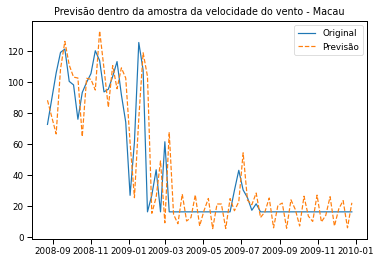

MSE : 1935.43824
RMSE: 43.99362
MAE : 14.92203
MAPE: 0.64067


In [ ]:
plot_predict_data(data,pred_old_gs,start,end)

> ORDER (16,0,24)  => [SEM DIFERENCIAÇÃO]
MSE : 1778.59690
***RMSE: 42.17341***
MAE : 16.47069
MAPE: 1.10881

> ORDER (8,0,20) => [SEM DIFERENCIAÇÃO]
MSE : 1796.52675;
**RMSE: 42.38545;**
MAE : 16.20733;
MAPE: 0.94148;

> ORDER (1,0,15)  => [SEM DIFERENCIAÇÃO]
MSE : 1810.51255;
**RMSE: 42.55012;**
MAE : 14.94681;
MAPE: 0.61371;

> ORDER (1,0,0)  => [SEM DIFERENCIAÇÃO]
MSE : 1809.90448;
**RMSE: 42.54297;**
MAE : 12.37713;
MAPE: 0.21156;

> ORDER (1,0,17)  => [SEM DIFERENCIAÇÃO]
MSE : 1807.94073;
**RMSE: 42.51989;**
MAE : 15.04112;
MAPE: 0.83058;

In [11]:
pred_gs1, model_fit_gs1 = predict_data(data,(16,0,24))

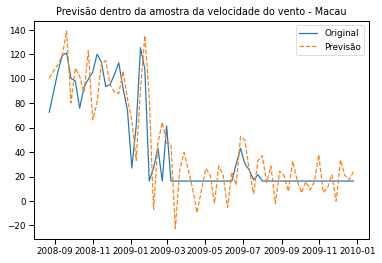

MSE : 1778.59690
RMSE: 42.17341
MAE : 16.47069
MAPE: 1.10881


In [12]:
plot_predict_data(data,pred_gs1,start,end)

> ORDER (16,2,1) => [COM DIFIERENCIAÇÃO]
MSE : 2354.29906;
**RMSE: 48.52112;**
MAE : 17.06219;
MAPE: 6953639153772955.00000;

> ORDER (3,1,11) => [COM DIFIERENCIAÇÃO]
MSE : 2065.80182;
**RMSE: 45.45109;**
MAE : 15.01082;
MAPE: 6953639153772955.00000;

> ORDER (10,3,22) => [COM DIFIERENCIAÇÃO]
MSE : 1809.90448
***RMSE: 42.54297***
MAE : 12.37713
MAPE: 0.21156

In [19]:
pred_gs2,model_fit_gs2 = predict_data(data,(10,2,22))

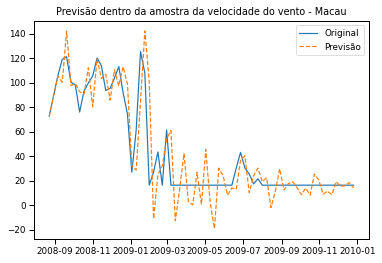

MSE : 2348.43245
RMSE: 48.46063
MAE : 17.81231
MAPE: 6953639153772957.00000


In [20]:
plot_predict_data(data,pred_gs2,start,end)

### Modelos obtidos com [AUTO-ARIMA]

> ORDER (3,0,2) => [TESTE ANTIGO]

In [ ]:
pred_old_aa, model_fit_old_aa = predict_data(data,(3,0,2))

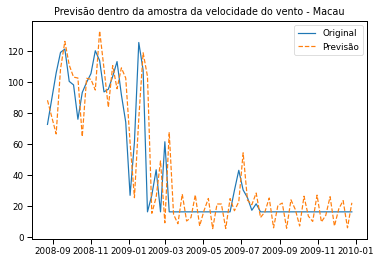

MSE : 1935.43824
RMSE: 43.99362
MAE : 14.92203
MAPE: 0.64067


In [ ]:
plot_predict_data(data,pred_old_aa,start,end)

> ORDER (1,0,1)

In [ ]:
pred_aa1, model_fit_aa1 = predict_data(data,(1,0,1))

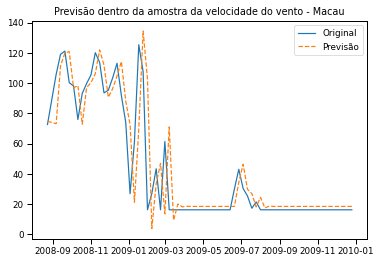

MSE : 1830.60021
RMSE: 42.78551
MAE : 12.95382
MAPE: 0.24817


In [ ]:
plot_predict_data(data,pred_aa1,start,end)

COM SAZONALIDADE

> ORDER (1,0,1)(2,0,0)[6]; **RMSE: 46.01136**

> ORDER (1,0,1)(0,0,1)[12]; **RMSE: 46.12994**

> ORDER (1,0,1)(2,0,1)[12]; **RMSE: 46.06985**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_model=SARIMAX(df.preco_medio, order=(1,0,1), seasonal_order=(2,0,1,12))
resultado_sarimax = sarimax_model.fit()

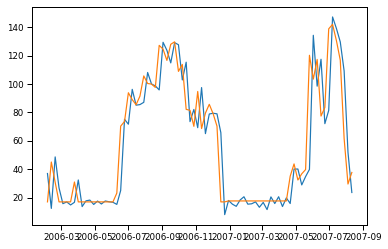

RMSE: 46.06985


In [ ]:
pred = resultado_sarimax.predict()
plt.plot(pred[240:320])
plt.plot(df.preco_medio[240:320])
plt.show()
rmse_sarima = sqrt(mean_squared_error(df.preco_medio.values, pred.values))
print("RMSE: {:.5f}".format(rmse_sarima))

## **Previsão Out Of Sample**

In [ ]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) - set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [ ]:
def forecast_data(data, params, steps):
    model = ARIMA(data, order=params)
    model_fit = model.fit()
    predictios = model_fit.forecast(steps)
    return predictios

In [ ]:
def data_frame(test, pred):
    dataset = DataFrame(test)
    dataset['previsao'] = pred
    dataset.dropna(inplace=True)
    return dataset

In [ ]:
def evaluate_error(orig, pred):
    print("MSE : {:.5f}".format(mean_squared_error(pred.values, orig.values)))
    print("RMSE: {:.5f}".format(np.sqrt(mean_squared_error(pred.values, orig.values))))
    print("MAE : {:.5f}".format(mean_absolute_error(pred.values, orig.values)))
    print("MAPE: {:.5f}".format(mean_absolute_percentage_error(pred.values, orig.values)))

In [ ]:
from pandas.core.frame import DataFrame
import warnings
from math import sqrt
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

def prediction(dataset, params, steps):
    # separa os dados em treino e teste
    x = dataset
    size = int(len(x) - steps)
    train, test = x[0:size], x[size:len(x)]

    prediction = []
    confM=[]
    confm=[]
    history = [x for x in train]
    for t in test.values:
        model = ARIMA(history, order=params).fit()
        y = model.forecast(steps=len(test))
        # y,err,ci = model.forecast(steps=len(test), alpha=0.05)
        # confm.append(ci[0][0])
        # confM.append(ci[0][1])
        prediction.append(y[0])
        history.append(t)
    test_ = DataFrame(test)
    test_['predictions_wf'] = prediction
    print(test_)
    # return test_, confm, confM
    return test_

In [ ]:
def plot_forecast(train, test, pred, length_train):
    plt.plot(train[len(train)-length_train:],color='teal',label='Treino')
    plt.plot(test,color='orangered',label='Teste')
    plt.plot(pred,'--',label='Previsão')
    plt.title("Previsão fora da amostra de vários passos com FORECAST")
    plt.legend()
    plt.show()
    print("MSE : {:.5f}".format(mean_squared_error(pred.values, test.values)))
    print("RMSE: {:.5f}".format(np.sqrt(mean_squared_error(pred.values, test.values))))
    print("MAE : {:.5f}".format(mean_absolute_error(pred.values, test.values)))
    print("MAPE: {:.5f}".format(mean_absolute_percentage_error(pred.values, test.values)))

In [ ]:
# def plot_prediction(train, test_, ci_m, ci_M, start):
def plot_prediction(train, test_, start):
    error = sqrt(mean_squared_error(test_.preco_medio.values, test_.predictions_wf.values))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(train[start:], label='Treino', color="teal")
    ax.plot(test_.preco_medio, label='Teste',color="orangered")
    ax.plot(test_.predictions_wf, '--,m', label='Previsão')
    # ax.fill_between(test_.predictions_wf.index,
    #                 ci_m,
    #                 ci_M, color='b', alpha=.15, label='conf. 95%')
    ax.set_title("Previsão do preço médio - PLD Norte")
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço médio (R$)')
    plt.suptitle(["RMSE:", round(error,3)])
    plt.legend()
    plt.show()
    print("MSE: " + str(mean_squared_error(test_['predictions_wf'], test_['preco_medio'])))
    print("RMSE: " + str(np.sqrt(mean_squared_error(test_['predictions_wf'], test_['preco_medio']))))
    print("MAE: " + str(mean_absolute_error(test_['predictions_wf'], test_['preco_medio'])))
    print("MAPE: " + str(mean_absolute_percentage_error(test_['predictions_wf'], test_['preco_medio'])))

In [ ]:
train_1step, test_1step = split_dataset(data, 1, True)


BASE DE TREINO
 inicio_semana
2009-11-21    16.31
2009-11-28    16.31
2009-12-05    16.31
2009-12-12    16.31
2009-12-19    16.31
Name: preco_medio, dtype: float64

BASE DE TESTE
 inicio_semana
2009-12-26    16.31
Name: preco_medio, dtype: float64


### Previsão de 1 passo [Pesquisa em grade]

> ORDER (3,0,2) => Modelo Antigo

In [ ]:
fc_gs = forecast_data(train_1step, (3,0,2),1)
fc_gs

442    21.826078
dtype: float64

In [ ]:
evaluate_error(test_1step[:1], fc_gs)

MSE : 30.42711
RMSE: 5.51608
MAE : 5.51608
MAPE: 0.25273


> ORDER (8,0,20) => [SEM DIFERENCIAÇÃO]

In [ ]:
fc_gs1 = forecast_data(train_1step, (8,0,20),1)
fc_gs1

442    18.042073
dtype: float64

In [ ]:
evaluate_error(test_1step[:1], fc_gs1)

MSE : 3.00008
RMSE: 1.73207
MAE : 1.73207
MAPE: 0.09600


### Previsão de 1 passo [AUTO-ARIMA]



> ORDER (3,0,2) => Teste Antigo

In [ ]:
fc_aa = forecast_data(train_1step, (3,0,2),1)
fc_aa

442    21.826078
dtype: float64

In [ ]:
evaluate_error(test_1step[:1], fc_aa)

MSE : 30.42711
RMSE: 5.51608
MAE : 5.51608
MAPE: 0.25273


> ORDER (1,0,1) => [SEM DIFERENCIAÇÃO]

In [ ]:
fc_aa1 = forecast_data(train_1step,(10,0,5),1)
fc_aa1

442    20.625473
dtype: float64

In [ ]:
evaluate_error(test_1step[:1], fc_aa1)

MSE : 18.62331
RMSE: 4.31547
MAE : 4.31547
MAPE: 0.20923


### Previsão de VARIOS passos [Pesquisa em grade]

In [ ]:
train, test = split_dataset(data, 14, False)

BASE DE TREINO:  429
BASE DE TESTE:   14


> ORDER (8,0,20) => [FORECAST]

In [ ]:
fc_gsN = forecast_data(train, (8,0,20),14)
fc_gsN

429    27.888021
430    23.314194
431    18.556510
432    16.859597
433    10.054333
434    35.923100
435    37.941980
436    23.947153
437    24.862528
438    10.911570
439    24.422501
440    36.041413
441    35.214037
442    36.366019
Name: predicted_mean, dtype: float64

In [ ]:
dataset_gs = data_frame(test, fc_gsN.values)
dataset_gs.head()

,preco_medio,previsao
inicio_semana,,
2009-09-26,16.31,27.888021
2009-10-03,16.31,23.314194
2009-10-10,16.31,18.556510
2009-10-17,16.31,16.859597
2009-10-24,16.31,10.054333


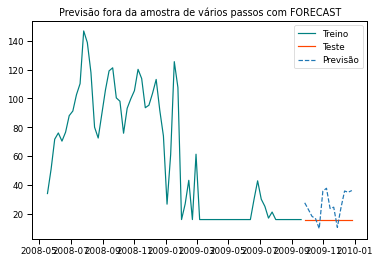

MSE : 175.39789
RMSE: 13.24379
MAE : 11.23365
MAPE: 0.40951


In [ ]:
plot_forecast(train, dataset_gs['preco_medio'],dataset_gs['previsao'], 70)

> ORDER (8,0,20) => [WalkForward]

In [ ]:
order = (8,0,20)
# test_,ci_M,ci_m = prediction(train, order, 7)
# order = (1,0,0)
test_gs = prediction(train, order, 7)

               preco_medio  predictions_wf
inicio_semana                             
2009-08-08           16.31       15.491932
2009-08-15           16.31       24.871265
2009-08-22           16.31        2.891772
2009-08-29           16.31       31.333026
2009-09-05           16.31       30.921825
2009-09-12           16.31       10.326074
2009-09-19           16.31       17.915560


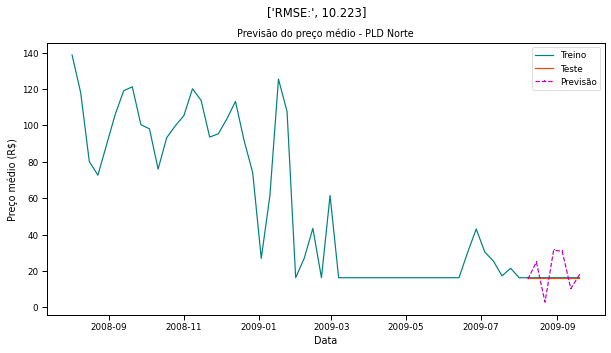

MSE: 104.51360691384811
RMSE: 10.223189664378143
MAE: 8.574556718484363
MAPE: 0.9511839203764857


In [ ]:
plot_prediction(train, test_gs, 370)

### Previsão de VARIOS passos [AUTO-ARIMA]

In [ ]:
train, test = split_dataset(data, 14, False)

BASE DE TREINO:  429
BASE DE TESTE:   14


> ORDER (1,0,1) => [FORECAST]

In [ ]:
fc_aaN = forecast_data(train, (1,0,1),14)
fc_aaN

429    17.672139
430    19.231005
431    20.741920
432    22.206359
433    23.625752
434    25.001484
435    26.334899
436    27.627298
437    28.879943
438    30.094056
439    31.270823
440    32.411393
441    33.516879
442    34.588360
Name: predicted_mean, dtype: float64

In [ ]:
dataset_aa = data_frame(test, fc_aaN.values)
dataset_aa.head()

,preco_medio,previsao
inicio_semana,,
2009-09-26,16.31,17.672139
2009-10-03,16.31,19.231005
2009-10-10,16.31,20.741920
2009-10-17,16.31,22.206359
2009-10-24,16.31,23.625752


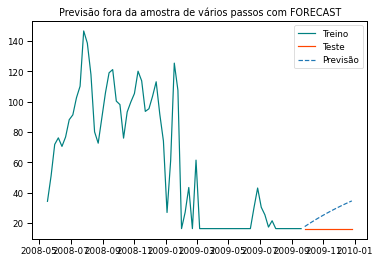

MSE : 134.54989
RMSE: 11.59956
MAE : 10.34731
MAPE: 0.36186


In [ ]:
plot_forecast(train, dataset_aa['preco_medio'],dataset_aa['previsao'], 70)

> ORDER (1,0,1) => [WalkForward]

In [ ]:
order = (1,0,1)
test_aa = prediction(train, order, 7)

               preco_medio  predictions_wf
inicio_semana                             
2009-08-08           16.31       16.653543
2009-08-15           16.31       18.843614
2009-08-22           16.31       18.624092
2009-08-29           16.31       17.696642
2009-09-05           16.31       17.685256
2009-09-12           16.31       17.681624
2009-09-19           16.31       17.676746


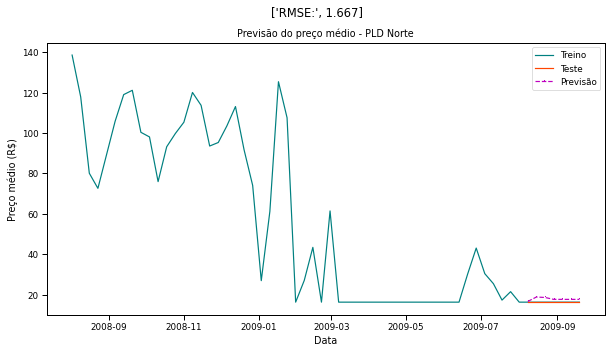

MSE: 2.779384523044855
RMSE: 1.6671486205629225
MAE: 1.5273594085935709
MAPE: 0.08433535965867614


In [ ]:
plot_prediction(train, test_aa, 370)